In [1]:
import numpy as np
sentence = ["আমি ভাত খাই","আমি ভাত খাই","আমি ভাত খাই","তুমি কেমন আছো","তুমি কেমন আছো","তুমি কেমন আছো",
            "আমার নাম রহিম","আমার নাম রহিম","আমার নাম রহিম","পুলিশকে ডাক","পুলিশকে ডাক","পুলিশকে ডাক","বিদায় নিচ্ছি","বিদায় নিচ্ছি",
            "বিদায় নিচ্ছি","একটি ভাষা যথেষ্ট নয়","একটি ভাষা যথেষ্ট নয়","একটি ভাষা যথেষ্ট নয়","সে কোন দেশের লোক","সে কোন দেশের লোক",
            "সে কোন দেশের লোক","আপনি কি বাংলা বলতে পারেন","আপনি কি বাংলা বলতে পারেন","আপনি কি বাংলা বলতে পারেন", "মাফ করবেন",
            "মাফ করবেন", "মাফ করবেন", "আমি তোমাকে ভালবাসি","আমি তোমাকে ভালবাসি","আমি তোমাকে ভালবাসি"]

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
from skimage import io, transform
import cv2

from skimage import color
from skimage import filters
from skimage import morphology, util
from skimage import morphology as mp;
import AdjustImage as ai
from skimage import img_as_uint

In [3]:
def rescale(img, sz):
    h,w = img.shape;
    scale = sz/h;
    #print(scale);
    img = np.array(img, dtype=np.uint8)
    img = cv2.resize(img,None,fx=scale,fy=scale)
    #from skimage import color
    #grey = color.rgb2gray(img)
    #from skimage import filters
    #threshold = filters.threshold_otsu(grey);
    #binary = grey > threshold;
    
    return img;

def resize2SquareKeepingAspectRation(img, size, interpolation):
    img = np.array(img, dtype=np.uint8)
    #img = rescale(img, 10);
    #io.imshow(img);
    h, w = img.shape[:2]
    c = None if len(img.shape) < 3 else img.shape[2]
    if h == w: return cv2.resize(img, (size, size), interpolation)
    if h > w: dif = h
    else: dif = w
    x_pos = int((dif - w)/2.)
    y_pos = int((dif - h)/2.)
    #print(x_pos, y_pos);
    if c is None:
        mask = np.ones((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
        #print(mask);
    else:
        mask = np.ones((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
        #print(mask);
    return cv2.resize(mask, (size, size), interpolation)

In [70]:
error_style = list();
error_len = np.zeros(6);
ercnt = 0;
for ind in range(1,(len(sentence)+1)):
    #input the image
    #if(ind==18): continue;
    lekha = cv2.imread('/media/s4k1b/Work/Study/Handwritting Recognition/sentence_image/tushar/'+str(ind)+'.png');
    #io.imshow(lekha);
    
    
    #preprocess the image
    grey = color.rgb2gray(lekha);
    threshold = filters.threshold_otsu(grey);
    binary = grey > threshold;
    inv = util.invert(binary);
    #closing = mp.binary_closing(inv);
    #opening = mp.binary_opening(closing);
    #row, col = binary.shape;
    #gunitok = 400/col;
    #reshaped = transform.resize(opening, (int(row*gunitok),int(col*gunitok)));
    crop = ai.adjustImage(inv, True);
    #crop = mp.skeletonize(crop);
    crop = util.invert(crop);
    #io.imshow(crop);
    
    
    
    #separate to words
    pixelcnt = list();
    for j in range(crop.shape[1]):
        cnt = 0;
        for i in range(crop.shape[0]):
            if(crop[i][j] == False):
                cnt = cnt + 1;
        pixelcnt.append(cnt);

    words = list();

    lastCrop = 0;
    index = 0;
    
    thresh = 10;
    #if(ind == 16 or ind == 18): thresh = 5;
    if(ind == 28): thresh = 14;
    #if(ind == 29): thresh = 10;
    #if(ind == 18): thresh = 13;
    #if(ind == 23): thresh = 7;
    
    
    while index < len(pixelcnt):
        #print("index = ",index);
        if(pixelcnt[index] == 0):
            zerocnt += 1;
        else:
            zerocnt = 0;

        if(zerocnt == thresh):
            #print(index-5+1);
            img = crop[:, lastCrop:index-thresh];
            words.append(resize2SquareKeepingAspectRation(ai.adjustImage(img, False), 64, cv2.INTER_AREA));
            zerocnt = 0;

            #find next collumn containing black pixel

            for nextindex in range(index, len(pixelcnt)):
                if(pixelcnt[nextindex] != False):
                    #print("nextindex= ",nextindex);
                    lastCrop = nextindex;
                    index = nextindex - 1;
                    break;
        index+=1;

    if(lastCrop < index - 1):
        words.append(resize2SquareKeepingAspectRation(ai.adjustImage(crop[:, lastCrop:len(pixelcnt)-1], False), 64, cv2.INTER_AREA));
        
        
    #save the data
    print(ind);
    wrd = sentence[ind-1].split(" ");
    if(len(wrd) != len(words)):
        if(len(wrd)>len(words)):print("text sentence is greater");
        else: print("image sentence is greater");
        print("Detected different words");
        ercnt+=1;
        error_len[len(wrd)-2]+=1;
    else:
        for i in range(len(wrd)):
            var = wrd[i];
            path = '/media/s4k1b/Work/Study/Handwritting Recognition/word_image/';
            os.makedirs(path+var, exist_ok = True);
            path+=var;
            print(path);
            cnt = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
            cnt+=1;
            #words[i].dtype = 'uint8';
            greyi = color.rgb2gray(words[i]);
            thresholdi = filters.threshold_otsu(greyi);
            binaryi = greyi > thresholdi;
            io.imsave(path+"/"+str(cnt)+".png",img_as_uint(binaryi));
print("error count", ercnt);
error_style.append(ercnt);

1
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/আমি
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/ভাত
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/খাই
2
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/আমি
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/ভাত
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/খাই
3
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/আমি
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/ভাত
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/খাই
4
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/তুমি
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/কেমন
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/আছো
5
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/তুমি
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/কেমন
/media/s4k1b/Work/Study/Handwritting Recognition/word_image/আছো
6
/media/s4k1b/Work/Study/

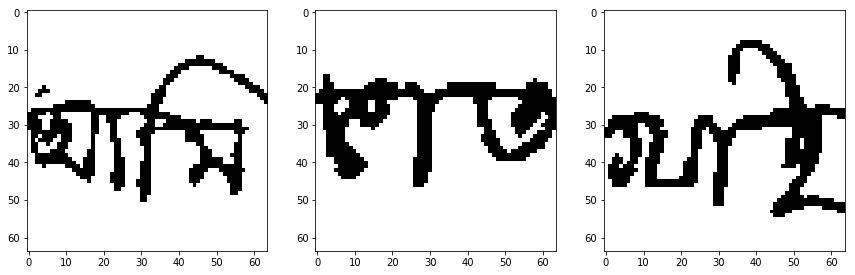

In [22]:
no_col = 5;
no_row = len(words)/no_col;
if((no_row%no_col)!=0):
    no_row+=1;

f = plt.figure(figsize=(25,10));
f.subplots_adjust(hspace=0.5, wspace=0.2)
for num,img in enumerate(words):
    a = f.add_subplot(no_row,no_col,num+1);
    #img = rescale(img, 64);
    a.imshow(img, cmap='Greys_r')